In [25]:
#Import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             roc_curve)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [26]:
# Paths and load dataset
DATA_PATH = "/content/diabetes.csv"
MODEL_DIR = "/content/model"
os.makedirs(MODEL_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose      

In [27]:

cols_with_zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero_as_missing] = df[cols_with_zero_as_missing].replace(0, np.nan)
imputer = SimpleImputer(strategy="median")
df[cols_with_zero_as_missing] = imputer.fit_transform(df[cols_with_zero_as_missing])


In [28]:
# Train
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
# Define models and cross-validation
scaler = StandardScaler()

# Pipelines
pipe_lr = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = Pipeline([
    ("scaler", scaler),
    ("clf", RandomForestClassifier(random_state=42))
])

# Cross-validation
models = {"LogisticRegression": pipe_lr, "RandomForest": pipe_rf}
cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                            return_train_score=False)
    cv_results[name] = {k: np.mean(v) for k, v in scores.items()}
    print(f"{name} CV results:", cv_results[name])


LogisticRegression CV results: {'fit_time': np.float64(0.01024165153503418), 'score_time': np.float64(0.024793338775634766), 'test_accuracy': np.float64(0.7817939490870318), 'test_precision': np.float64(0.7397737556561086), 'test_recall': np.float64(0.5843853820598006), 'test_f1': np.float64(0.6496858824779203), 'test_roc_auc': np.float64(0.8432876522702104)}
RandomForest CV results: {'fit_time': np.float64(0.22569899559020995), 'score_time': np.float64(0.03262209892272949), 'test_accuracy': np.float64(0.7687724910035986), 'test_precision': np.float64(0.7108098208098209), 'test_recall': np.float64(0.57984496124031), 'test_f1': np.float64(0.6363106081885423), 'test_roc_auc': np.float64(0.8228848283499446)}


In [30]:
# Hyperparameter tuning for RandomForest
param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=4, scoring="roc_auc", n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("RF best params:", grid_rf.best_params_, "best score:", grid_rf.best_score_)


RF best params: {'clf__max_depth': 6, 'clf__min_samples_split': 2, 'clf__n_estimators': 100} best score: 0.8356804682040532


In [31]:
# Fit final models and evaluate
pipe_lr.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

def evaluate(model, Xt, yt):
    ypred = model.predict(Xt)
    yprob = model.predict_proba(Xt)[:, 1]
    return {
        "accuracy": accuracy_score(yt, ypred),
        "precision": precision_score(yt, ypred),
        "recall": recall_score(yt, ypred),
        "f1": f1_score(yt, ypred),
        "roc_auc": roc_auc_score(yt, yprob),
        "confusion_matrix": confusion_matrix(yt, ypred),
        "classification_report": classification_report(yt, ypred)
    }

res_lr = evaluate(pipe_lr, X_test, y_test)
res_rf = evaluate(best_rf, X_test, y_test)

print("Logistic Regression test results:\n", res_lr)
print("Random Forest test results:\n", res_rf)

pipe_lr.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

def evaluate(model, Xt, yt):
    ypred = model.predict(Xt)
    yprob = model.predict_proba(Xt)[:, 1]
    return {
        "accuracy": accuracy_score(yt, ypred),
        "precision": precision_score(yt, ypred),
        "recall": recall_score(yt, ypred),
        "f1": f1_score(yt, ypred),
        "roc_auc": roc_auc_score(yt, yprob),
        "confusion_matrix": confusion_matrix(yt, ypred),
        "classification_report": classification_report(yt, ypred)
    }

res_lr = evaluate(pipe_lr, X_test, y_test)
res_rf = evaluate(best_rf, X_test, y_test)

print("Logistic Regression test results:\n", res_lr)
print("Random Forest test results:\n", res_rf)


Logistic Regression test results:
 {'accuracy': 0.7077922077922078, 'precision': 0.6, 'recall': 0.5, 'f1': 0.5454545454545454, 'roc_auc': np.float64(0.812962962962963), 'confusion_matrix': array([[82, 18],
       [27, 27]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.75      0.82      0.78       100\n           1       0.60      0.50      0.55        54\n\n    accuracy                           0.71       154\n   macro avg       0.68      0.66      0.67       154\nweighted avg       0.70      0.71      0.70       154\n'}
Random Forest test results:
 {'accuracy': 0.7402597402597403, 'precision': 0.6666666666666666, 'recall': 0.5185185185185185, 'f1': 0.5833333333333334, 'roc_auc': np.float64(0.817037037037037), 'confusion_matrix': array([[86, 14],
       [26, 28]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.77      0.86      0.81       100\n           1       0.67  

In [32]:
# Select best model by ROC AUC
best_model = best_rf if res_rf["roc_auc"] >= res_lr["roc_auc"] else pipe_lr
print("Selected model:", best_model)

# Save model & scaler
joblib.dump(best_model, os.path.join(MODEL_DIR, "best_model.pkl"))
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))

# Save metrics summary
metrics_summary = {
    "LogisticRegression": {k: float(v) for k, v in res_lr.items() if k not in ["confusion_matrix", "classification_report"]},
    "RandomForest": {k: float(v) for k, v in res_rf.items() if k not in ["confusion_matrix", "classification_report"]},
}
with open(os.path.join(MODEL_DIR, "metrics.json"), "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("Model and metrics saved in:", MODEL_DIR)


Selected model: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(max_depth=6, random_state=42))])
Model and metrics saved in: /content/model


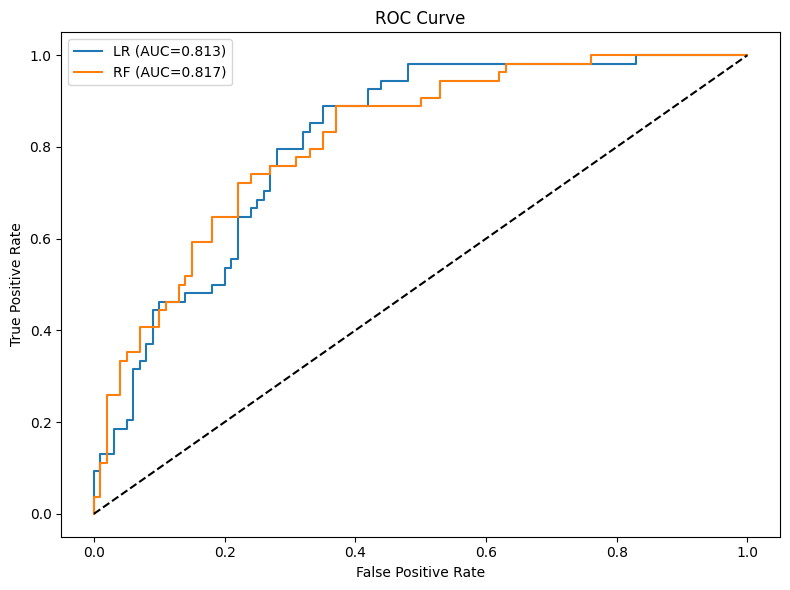

In [33]:
# Plot ROC curves
plt.figure(figsize=(8,6))
for name, model in [("LR", pipe_lr), ("RF", best_rf)]:
    yprob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, yprob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, yprob):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "roc_curves.png"))
plt.show()

In [34]:
X_skin = df[['BMI']]
y_skin = df['SkinThickness']

# Train linear regression model
skin_model = LinearRegression()
skin_model.fit(X_skin, y_skin)

# Save the skin thickness estimator model
joblib.dump(skin_model, os.path.join(MODEL_DIR, "skin_thickness_estimator.pkl"))

print("Skin thickness estimator model trained and saved.")


Skin thickness estimator model trained and saved.
